In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels
import bumps

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

In [20]:
true_reads = pd.read_csv('../Fit_Truths.csv')
true_reads = true_reads.to_numpy()
mask = true_reads[:,1].astype(bool)

sphere_keys = true_reads[mask,0]

In [21]:
true_reads = pd.read_csv('../Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Sphere')[0]

final_keys = true_reads[mask,0]

In [24]:
final_keys

array([1, 6, 7, 8, 9, 11, 12, 13, 16, 22, 25, 32, 101, 108, 109, 203, 301,
       501, 502, 503], dtype=object)

In [25]:
# sample meta-data
sample_info = pd.read_csv('../Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act
    actual_stdev[key] = stdev
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # density 1.13
       'Polystyrene-H8':1.426}


In [26]:
data_dir = '../Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [27]:
background_files = [file for file in os.listdir('../PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [28]:
power_law_fit_info = pd.read_json('../PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [29]:
guinier_porod_fit = pd.read_json('../PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [30]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [31]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [32]:
porod_files = [file for file in os.listdir('../Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

Loading fit parameters from the results directory.

In [33]:
results_direct = 'fitting_results/ps_sphere/'
fit_keys = []
# fit_ps_porod_exp = {}
# fit_ps_rg = {}
# fit_ps_s = {}
# fit_ps_scale = {}
fit_sphere_radius= {}
fit_sphere_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
#         if 'porod_exp' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_porod_exp[key] = (best, ci95)
#         elif 'rg' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_rg[key] = (best, ci95)
#         elif 'PS scale' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_scale[key] = (best, ci95)
#         elif 'PS s' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_s[key] = (best, ci95)
        if 'radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_radius[key] = (best, ci95)
        elif 'sphere scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_scale[key] = (best, ci95)
        


Convenient dictionaries for plotting.

In [34]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key] + '\nfrom ' + solvent_names[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


In [35]:
for key in fit_keys:
    
    plt.figure(figsize=(6,6))
    
    kernel = load_model('guinier_porod+sphere')

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100
    
    # model parameters
    
    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')
    
    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')
    
    B_scale = Parameter(fit_sphere_scale[key][0], name=str(key) + ' sphere scale')
    
    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
    
    B_radius = Parameter(fit_sphere_radius[key][0], limits=[0,inf], name=str(key) + ' sphere radius')
    B_radius_pd = Parameter(0.5, name = str(key) + ' sphere radius pd')
    B_radius_pd_n = Parameter(200, name = str(key) + ' sphere radius pd n')
    B_radius_pd_nsigma = Parameter(8, name = str(key) + ' sphere radius pd nsigma') 
    
    # setting up the combined model for plotting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius=B_radius,
        B_radius_pd_type='lognormal',
        B_radius_pd=B_radius_pd,
        B_radius_pd_n=B_radius_pd_n,
        B_radius_pd_nsigma=B_radius_pd_nsigma,
    )
    
    
    sans = sans_data[key]
    sans.dx = sans.dx - sans.dx
    plt.errorbar(sans.x, sans.y, yerr=sans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    usans = usans_data[key]
    plt.errorbar(usans.x, usans.y, yerr=usans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    sans_problem=FitProblem(sans_experiment)
    usans_problem=FitProblem(usans_experiment)
    
    plt.plot(sans.x, sans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)
    plt.plot(usans.x, usans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(1e-03, 1e11)
    plt.xlim(0.00002, 0.3)

    plt.title(full_names[key] + ' (Sample ' + str(key) + ')', fontsize=16)

    #plt.show()
    plt.tight_layout()
    plt.savefig('fitting_figures/ps_sphere/CMW' + str(key) + '_PS_Sphere_Fit.png', dpi=400)
    plt.close()




Plotting the sphere radius as a function of conjugated polymer wt%.

In [48]:
rre_cf = [key for key in final_keys if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
rra_cf = [key for key in final_keys if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
p3ddt_cf = [key for key in final_keys if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
pqt_cf = [key for key in final_keys if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 

rre_tol = [key for key in final_keys if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
rre_bb = [key for key in final_keys if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
rre_cf_slow = [key for key in final_keys if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 

p3ddt_tol = [key for key in final_keys if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
p3ddt_bb = [key for key in final_keys if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']


In [101]:
max(fit_sphere_radius.values())

(8244.187263635033, [8241.40965461415, 8246.924624025238])

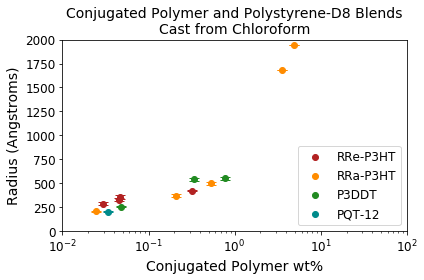

In [108]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='RRe-P3HT', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rra_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='RRa-P3HT', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='P3DDT', color='forestgreen')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='forestgreen', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in pqt_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='PQT-12', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')



plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Radius (Angstroms)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0,2000)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/CF_radius.png', dpi=300)

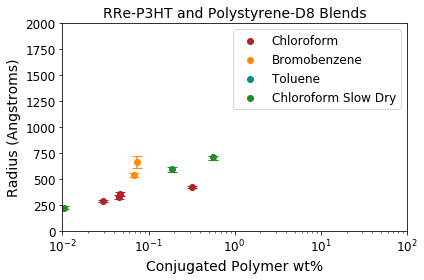

In [109]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Chloroform', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_bb:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Bromobenzene', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_tol:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Toluene', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf_slow:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Chloroform Slow Dry', color='forestgreen')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='forestgreen', label=None, fmt='none')


plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Radius (Angstroms)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0,2000)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/RReP3HT_radius.png', dpi=300)

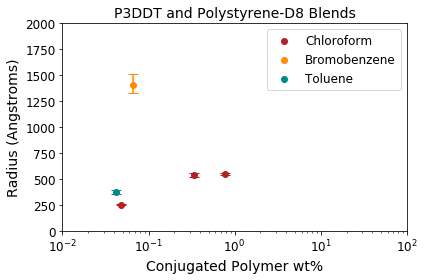

In [110]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_cf:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Chloroform', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_bb:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Bromobenzene', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_tol:
    wtP.append(actual[key])
    radius_list.append(fit_sphere_radius[key][0])
    radius_95_mid.append((fit_sphere_radius[key][1][1]+fit_sphere_radius[key][1][0])/2)
    radius_95_width.append(fit_sphere_radius[key][1][1]-fit_sphere_radius[key][1][0])

plt.scatter(wtP, radius_list, label='Toluene', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')


plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Radius (Angstroms)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0,2000)

plt.title('P3DDT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/P3DDT_radius.png', dpi=300)

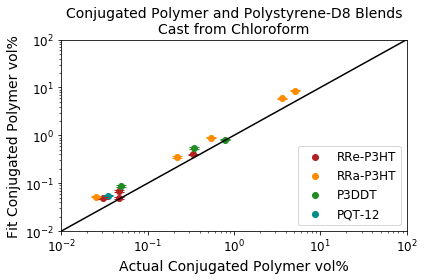

In [98]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='RRe-P3HT', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rra_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='RRa-P3HT', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='P3DDT', color='forestgreen')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='forestgreen', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in pqt_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='PQT-12', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')

plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.01,100)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/CF_scales.png', dpi=300)

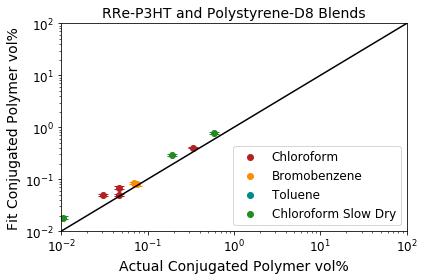

In [99]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Chloroform', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_bb:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Bromobenzene', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')




wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_tol:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Toluene', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in rre_cf_slow:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Chloroform Slow Dry', color='forestgreen')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='forestgreen', label=None, fmt='none')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')

plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.01,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/RReP3HT_scales.png', dpi=300)

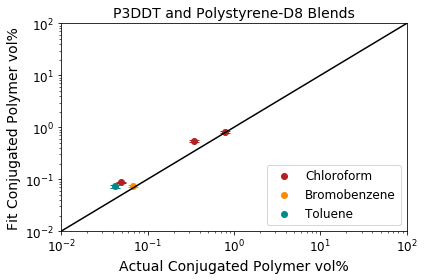

In [100]:
wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_cf:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Chloroform', color='firebrick')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='firebrick', label=None, fmt='none')


wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_bb:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Bromobenzene', color='darkorange')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkorange', label=None, fmt='none')




wtP = []
radius_list = []
radius_95_mid = []
radius_95_width = []

for key in p3ddt_tol:
    wtP.append(actual_vol[key])
    radius_list.append(fit_sphere_scale[key][0]*100)
    radius_95_mid.append((fit_sphere_scale[key][1][1]+fit_sphere_scale[key][1][0])*100/2)
    radius_95_width.append((fit_sphere_scale[key][1][1]-fit_sphere_scale[key][1][0])*100)

plt.scatter(wtP, radius_list, label='Toluene', color='darkcyan')
plt.errorbar(wtP, radius_95_mid, yerr=radius_95_width, capsize=5, c='darkcyan', label=None, fmt='none')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')

plt.xscale('log')
plt.xlim(0.01,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.01,100)

plt.title('P3DDT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('fitting_figures/ps_sphere/P3DDT_scales.png', dpi=300)